In [1]:
from pprint import pprint
import time
import ee
import folium
import csv
import sys
import tensorflow as tf
from tensorflow import keras
import json
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn import linear_model

In [2]:
print(tf.__version__)
print(sys.version)

2.1.0
3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]


In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

In [4]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(bands).divide(10000)

# The image input data is a 2018 cloud-masked median composite.
image = l8sr.filterDate('2018-01-01', '2018-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapIdDict = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[45.4, -75.7])
folium.TileLayer(
    tiles=mapIdDict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [5]:
trainFileCSV = '../TFData/Training Export.csv'
testFileCSV = '../TFData/Testing Export.csv'

print('Found training file.' if tf.io.gfile.exists(trainFileCSV) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFileCSV) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [9]:
trainCSV = np.genfromtxt(trainFileCSV, delimiter=',', names=True)

trainFrame = DataFrame(trainCSV, columns=['B3', 'B5', 'B6', 'B7', 'B4'])
trainFrame

,B3,B5,B6,B7,B4
0,0.05630,0.19920,0.13325,0.08235,0.05220
1,0.05790,0.27850,0.15070,0.07750,0.03885
2,0.04130,0.22070,0.08350,0.04080,0.02430
3,0.05230,0.24485,0.13105,0.06895,0.03510
4,0.05910,0.31160,0.13560,0.07590,0.03910
...,...,...,...,...,...
21329,0.05570,0.22230,0.07560,0.04870,0.04160
21330,0.05560,0.20435,0.05960,0.04425,0.03825
21331,0.06415,0.21725,0.07755,0.04775,0.04945
21332,0.18335,0.32295,0.09425,0.06630,0.16990


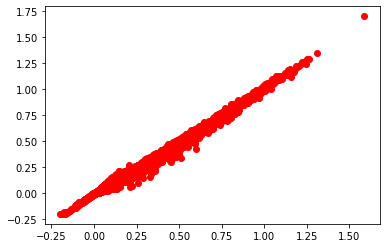

In [10]:
plt.plot(trainFrame['B3'], trainFrame['B4'], 'ro')

In [109]:
X = trainFrame[['B3', 'B5', 'B6', 'B7']]
Y = trainFrame['B4']

lars = linear_model.LassoLars(alpha=0.0001)
lars.fit(X, Y)
print(lars.score(X, Y))
print(lars.coef_)

0.9911845882505922
[0.92859647 0.         0.         0.        ]


In [40]:
testCSV = np.genfromtxt(testFileCSV, delimiter=',', names = True)

testFrame = DataFrame(testCSV, columns=['B3', 'B5', 'B6', 'B7'])
testFrame

,B3,B5,B6,B7
0,0.02930,0.15870,0.05980,0.02865
1,0.05800,0.25490,0.14685,0.08475
2,0.03860,0.22190,0.09080,0.04120
3,0.04065,0.17350,0.08980,0.04655
4,0.04940,0.18380,0.10275,0.05945
...,...,...,...,...
9061,0.45450,0.46765,0.08490,0.07265
9062,0.04655,0.17545,0.07310,0.03795
9063,0.06980,0.21670,0.10840,0.06720
9064,0.15555,0.26230,0.08210,0.04835


In [46]:
predictions = lars.predict(testFrame)

validationFrame = DataFrame(testCSV, columns=['B4'])
r2 = lars.score(testFrame, validationFrame)
validationFrame

,B4
0,0.01780
1,0.04605
2,0.02260
3,0.02950
4,0.03245
...,...
9061,0.44185
9062,0.02655
9063,0.06420
9064,0.15595


In [50]:
validationFrame['Predicted'] = predictions
RMSE = ((validationFrame.Predicted - validationFrame.B4) ** 2).mean() ** .5

print(r2)
print(RMSE)

0.996478007226406
0.01167436982069765


In [51]:
BCexport = '../TFData/BC Image Export.csv'
SaharaExport = '../TFData/Sahara Image Export.csv'

print('Found training file.' if tf.io.gfile.exists(trainFileCSV) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFileCSV) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [53]:
BCdata = np.genfromtxt(BCexport, delimiter=',', names = True)

BCtest = DataFrame(BCdata, columns=['B3', 'B5', 'B6', 'B7'])
BCtest

,B3,B5,B6,B7
0,0.04100,0.18895,0.05830,0.03805
1,0.06710,0.20605,0.07260,0.04690
2,0.05265,0.17895,0.05620,0.03485
3,0.06755,0.18925,0.05565,0.03770
4,0.04570,0.22380,0.08320,0.04780
...,...,...,...,...
1239036,0.05420,0.21785,0.11640,0.07620
1239037,0.05420,0.21785,0.11640,0.07620
1239038,0.08110,0.22755,0.11685,0.07555
1239039,0.04795,0.19290,0.05970,0.04095


In [54]:
BCpredictions = lars.predict(BCtest)

BCvalidations = DataFrame(BCdata, columns=['B4'])
BC_r2 = lars.score(BCtest, BCvalidations)
BCvalidations

,B4
0,0.04220
1,0.07160
2,0.04415
3,0.05825
4,0.04350
...,...
1239036,0.07220
1239037,0.07220
1239038,0.09805
1239039,0.04560


In [55]:
BCvalidations['Predicted'] = BCpredictions
BC_RMSE = ((BCvalidations.Predicted - BCvalidations.B4) ** 2).mean() ** .5

print(BC_r2)
print(BC_RMSE)

0.9831095041964283
0.011124098430193356


/home/hshah/anaconda3/envs/eeAlr/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


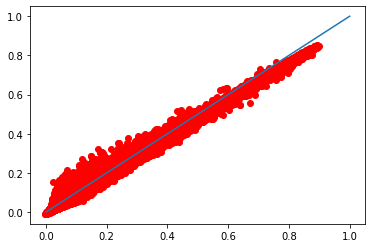

In [73]:
plt.plot(BCvalidations['B4'], BCvalidations['Predicted'], 'ro')
ax = plt.axes()
x = np.linspace(0, 1, 1000)
ax.plot(x, x)
plt.show()

In [57]:
SaharaData = np.genfromtxt(SaharaExport, delimiter=',', names = True)

SaharaTest = DataFrame(SaharaData, columns=['B3', 'B5', 'B6', 'B7'])
SaharaTest

,B3,B5,B6,B7
0,0.30815,0.60645,0.73485,0.65110
1,0.31225,0.61735,0.75595,0.67270
2,0.31285,0.61405,0.75040,0.66865
3,0.31175,0.60985,0.74485,0.65835
4,0.31085,0.60645,0.74045,0.65450
...,...,...,...,...
1239028,0.32260,0.63885,0.78160,0.69070
1239029,0.31665,0.62295,0.75735,0.67125
1239030,0.31505,0.62255,0.75515,0.67310
1239031,0.31500,0.61590,0.75145,0.66805


In [58]:
SaharaPredictions = lars.predict(SaharaTest)

SaharaValidations = DataFrame(SaharaData, columns=['B4'])
Sahara_r2 = lars.score(SaharaTest, SaharaValidations)
SaharaValidations

,B4
0,0.49710
1,0.50615
2,0.50415
3,0.50105
4,0.49795
...,...
1239028,0.52655
1239029,0.51155
1239030,0.51055
1239031,0.50730


In [68]:
SaharaValidations['Predicted'] = SaharaPredictions
Sahara_RMSE = ((SaharaValidations.Predicted - SaharaValidations.B4) ** 2).mean() ** .5

print(Sahara_r2)
print(Sahara_RMSE)

-43.66089306540057
0.12259647777144031


/home/hshah/anaconda3/envs/eeAlr/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


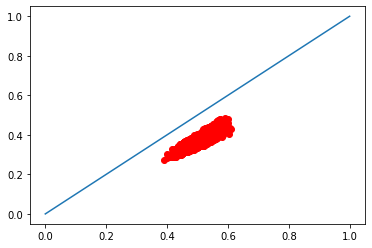

In [74]:
plt.plot(SaharaValidations['B4'], SaharaValidations['Predicted'], 'ro')
axes = plt.axes()
axes.plot(x, x)
plt.show()

In [119]:
featureBands = ['B3', 'B5', 'B6', 'B7']

In [120]:
selectBands = [featureBands[i] for i in np.nonzero(lars.coef_)[0].tolist()]

In [121]:
selectBands

['B3']

In [122]:
trainFilePath = '../TFData/Training Export.tfrecord.gz'
testFilePath = '../TFData/Testing Export.tfrecord.gz'

print('Found training file.' if tf.io.gfile.exists(trainFilePath) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFilePath) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [123]:
# Create a dataset from the TFRecord file in Cloud Storage.
trainDataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')
# Print the first record to check.
print(iter(trainDataset).next())

tf.Tensor(b'\n`\n\x0e\n\x02B2\x12\x08\x12\x06\n\x04vO\x1e=\n\x0e\n\x02B3\x12\x08\x12\x06\n\x04\xd4\x9af=\n\x0e\n\x02B4\x12\x08\x12\x06\n\x04\xab\xcfU=\n\x0e\n\x02B5\x12\x08\x12\x06\n\x04\x16\xfbK>\n\x0e\n\x02B6\x12\x08\x12\x06\n\x04\xb0r\x08>\n\x0e\n\x02B7\x12\x08\x12\x06\n\x04\x1e\xa7\xa8=', shape=(), dtype=string)


In [134]:
# This is list of all the properties we want to export.
featureNames = list(selectBands)
featureNames.append('B4')

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in featureNames
]

# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

pprint(featuresDict)

{'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [135]:
def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  band4 = parsed_features.pop('B4')
  return parsed_features, band4

# Map the function over the dataset.
parsedDataset = trainDataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
pprint(iter(parsedDataset).next())

({'B3': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0563], dtype=float32)>},
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0522], dtype=float32)>)


In [136]:
def toTuple(dict, label):
  return tf.transpose(list(dict.values())), label

# Define the layers in the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.tanh),
  tf.keras.layers.Dense(10)
])

inputDataset = parsedDataset.map(toTuple)
pprint(iter(inputDataset).next())

# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='mean_squared_error',
              metrics=['MAE'])

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0563]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0522], dtype=float32)>)


In [137]:
# Fit the model to the training data.
model.fit(x=inputDataset, epochs=10)

testDataset = (
  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .map(toTuple)
)

model.evaluate(testDataset)

Epoch 1/10
21334/21334 [==============================] - 89s 4ms/step - loss: 0.0104 - MAE: 0.0423
Epoch 2/10
21334/21334 [==============================] - 31s 1ms/step - loss: 3.1261e-04 - MAE: 0.0096
Epoch 3/10
21334/21334 [==============================] - 39s 2ms/step - loss: 2.8665e-04 - MAE: 0.0092
Epoch 4/10
21334/21334 [==============================] - 34s 2ms/step - loss: 2.6730e-04 - MAE: 0.0090
Epoch 5/10
21334/21334 [==============================] - 29s 1ms/step - loss: 2.5228e-04 - MAE: 0.0087
Epoch 6/10
21334/21334 [==============================] - 30s 1ms/step - loss: 2.4039e-04 - MAE: 0.0086
Epoch 7/10
21334/21334 [==============================] - 31s 1ms/step - loss: 2.3078e-04 - MAE: 0.0084
Epoch 8/10
21334/21334 [==============================] - 29s 1ms/step - loss: 2.2289e-04 - MAE: 0.0083
Epoch 9/10
21334/21334 [==============================] - 35s 2ms/step - loss: 2.1632e-04 - MAE: 0.0082
Epoch 10/10
21334/21334 [==============================] - 31s 1ms/s

[0.00020871249912560595, 0.00800327]

In [138]:
filesList = !ls '../TFData'
exportFilesList = [s for s in filesList if 'BC Image Export' in s]

imageFilesList=[]
jsonFile = None
for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
        imageFilesList.append('../TFData/'+f)
    elif f.endswith('.json'):
        jsonFile = '../TFData/'+f
        
imageFilesList.sort()

pprint(imageFilesList)
print(jsonFile)

['../TFData/BC Image Export-00000.tfrecord.gz',
 '../TFData/BC Image Export-00001.tfrecord.gz',
 '../TFData/BC Image Export-00002.tfrecord.gz']
../TFData/BC Image Export-mixer.json


In [139]:
jsonText = !cat '{jsonFile}'
mixer = json.loads(jsonText.nlstr)
pprint(mixer)

{'patchDimensions': [256, 256],
 'patchesPerRow': 14,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            -122.00019873627222,
                                            0.0,
                                            -0.00026949458523585647,
                                            59.00098853485653]},
                'crs': 'EPSG:4326'},
 'totalPatches': 196}


In [142]:
# Get relevant info from the JSON mixer file.
PATCH_WIDTH = mixer['patchDimensions'][0]
PATCH_HEIGHT = mixer['patchDimensions'][1]
PATCHES = mixer['totalPatches']
PATCH_DIMENSIONS_FLAT = [PATCH_WIDTH * PATCH_HEIGHT, 1]

testBands = featureNames

# Note that the tensors are in the shape of a patch, one patch for each band.
imageColumns = [
  tf.io.FixedLenFeature(shape=PATCH_DIMENSIONS_FLAT, dtype=tf.float32) 
    for k in testBands
]

# Parsing dictionary.
imageFeaturesDict = dict(zip(testBands, imageColumns))

# Note that you can make one dataset from many files by specifying a list.
imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')

# Parsing function.
def parse_image(example_proto):
    parsed_image = tf.io.parse_single_example(example_proto, imageFeaturesDict)
    band4 = parsed_image.pop('B4')
    return parsed_image

def parse_output(example_proto):
    parsed_output = tf.io.parse_single_example(example_proto, imageFeaturesDict)
    band4 = parsed_output.pop('B4')
    return band4

outputDataset = imageDataset.map(parse_output, num_parallel_calls=5)

# Parse the data into tensors, one long tensor per patch.
imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)


# Break our long tensors into many little ones.
imageDataset = imageDataset.flat_map(
  lambda features: tf.data.Dataset.from_tensor_slices(features)
)

# Turn the dictionary in each record into a tuple without a label.
imageDataset = imageDataset.map(
  lambda dataDict: (tf.transpose(list(dataDict.values())), )
)

# Turn each patch into a batch.
imageDataset = imageDataset.batch(PATCH_WIDTH * PATCH_HEIGHT)

In [151]:
print(iter(imageDataset).next())

(<tf.Tensor: shape=(65536, 1, 1), dtype=float32, numpy=
array([[[0.14685]],

       [[0.14685]],

       [[0.05795]],

       ...,

       [[0.043  ]],

       [[0.0476 ]],

       [[0.0476 ]]], dtype=float32)>,)


In [143]:
# Run prediction in batches, with as many steps as there are patches.
predictions = model.predict(imageDataset, steps=PATCHES, verbose=1)

196/196 [==============================] - 1086s 6s/step


In [144]:
# Note that the predictions come as a numpy array.  Check the first one.
print(predictions[190])

[[0.06830296 0.06815866 0.0681973  0.06806378 0.06824458 0.06801295
  0.06803256 0.0680116  0.06813239 0.06814337]]


In [145]:
predicted = [(sum(k[0])/len(k[0])) for k in predictions]

In [146]:
outputted = np.vstack(list(outputDataset.as_numpy_iterator()))

/home/hshah/anaconda3/envs/eeAlr/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


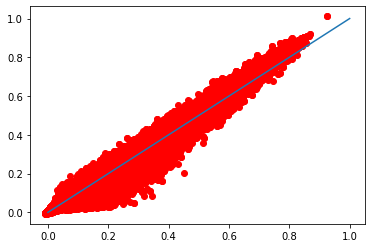

In [149]:
plt.plot(predicted, outputted, 'ro')
axs = plt.axes()
axs.plot(x, x)
plt.show()